## Generative Adversarial Networks (GANs) in PyTorch


In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
DATA_DIR = '/kaggle/input/plants-village-with-whiteflies-and-spidermites'

In [3]:
image_size = 64
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
    ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [5]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

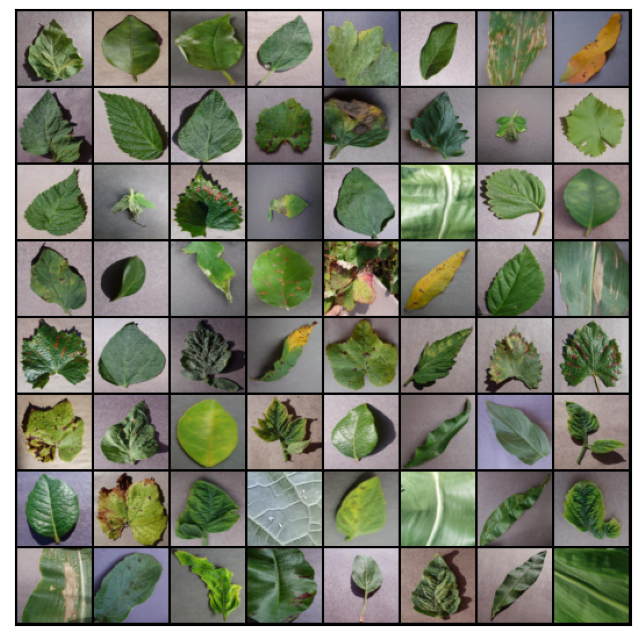

In [8]:
show_batch(train_dl)

## Using a GPU

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

## GAN Overview

A generative adversarial network (GAN) has two parts:

* The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator.
* The discriminator learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.

Here are the steps a GAN takes:

* The generator takes in random numbers and returns an image.
* This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground-truth dataset.
* The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

![](https://wiki.pathmind.com/images/wiki/gan_schema.png)

Example:
![](https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg)
As training progresses, the generator gets closer to producing output that can fool the discriminator:
![](https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg)
![](https://developers.google.com/static/machine-learning/gan/images/good_gan.svg)


## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. I'll use a convolutional neural networks (CNN) which outputs a single number output for every image. I'll use stride of 2 to progressively reduce the size of the output feature map.

Blue maps are inputs, and cyan maps are outputs.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

## Generator Network

The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator. It learns to make the discriminator classify its output as real.

In ConvTranspose2d network padding and stride happens like below:

![](https://camo.githubusercontent.com/4f47a1960462f9c44776cb98be5fc22538766b0bccc54a772c837f4d98254b27/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f3230313339372f32316661666564302d613934392d653539392d656663362d3233343439633036396433632e706e67)

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_transposed.gif)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [17]:
generator = to_device(generator, device)

## Discriminator Training

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [20]:
from torchvision.utils import save_image

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


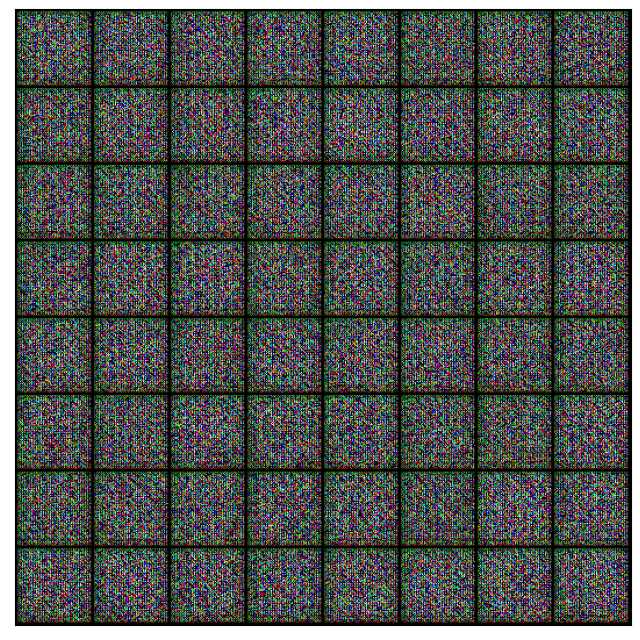

In [24]:
save_samples(0, fixed_latent)

## Full Training Loop

In [25]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [29]:
%%time
lr = 0.001
epochs = 200
history = fit(epochs, lr)

  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 1.9744, loss_d: 0.1397, real_score: 0.8915, fake_score: 0.0099
Saving generated-images-0001.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 3.9280, loss_d: 0.0598, real_score: 0.9702, fake_score: 0.0263
Saving generated-images-0002.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 2.3428, loss_d: 0.3345, real_score: 0.8286, fake_score: 0.0395
Saving generated-images-0003.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 5.4176, loss_d: 0.0267, real_score: 0.9837, fake_score: 0.0095
Saving generated-images-0004.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 5.3673, loss_d: 0.6040, real_score: 0.9302, fake_score: 0.3009
Saving generated-images-0005.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 4.4946, loss_d: 0.3391, real_score: 0.9166, fake_score: 0.1533
Saving generated-images-0006.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 5.1401, loss_d: 0.0870, real_score: 0.9510, fake_score: 0.0256
Saving generated-images-0007.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 4.6911, loss_d: 0.1032, real_score: 0.9459, fake_score: 0.0389
Saving generated-images-0008.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 5.3375, loss_d: 0.1667, real_score: 0.9222, fake_score: 0.0523
Saving generated-images-0009.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 2.7507, loss_d: 0.2045, real_score: 0.8619, fake_score: 0.0133
Saving generated-images-0010.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 4.4910, loss_d: 0.3612, real_score: 0.9164, fake_score: 0.1354
Saving generated-images-0011.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 3.3104, loss_d: 0.1731, real_score: 0.8897, fake_score: 0.0214
Saving generated-images-0012.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 5.9341, loss_d: 0.0387, real_score: 0.9698, fake_score: 0.0065
Saving generated-images-0013.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 5.3858, loss_d: 0.0330, real_score: 0.9999, fake_score: 0.0296
Saving generated-images-0014.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 1.3859, loss_d: 1.8049, real_score: 0.7051, fake_score: 0.5539
Saving generated-images-0015.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 3.0173, loss_d: 0.2177, real_score: 0.8791, fake_score: 0.0311
Saving generated-images-0016.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 1.2133, loss_d: 0.6164, real_score: 0.6947, fake_score: 0.0026
Saving generated-images-0017.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 3.8500, loss_d: 0.2184, real_score: 0.8842, fake_score: 0.0596
Saving generated-images-0018.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 5.1530, loss_d: 0.0683, real_score: 0.9851, fake_score: 0.0458
Saving generated-images-0019.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 2.3698, loss_d: 0.2373, real_score: 0.8187, fake_score: 0.0107
Saving generated-images-0020.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 8.4250, loss_d: 0.0186, real_score: 0.9996, fake_score: 0.0171
Saving generated-images-0021.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 9.4705, loss_d: 0.2906, real_score: 0.9885, fake_score: 0.2001
Saving generated-images-0022.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 6.3093, loss_d: 0.0445, real_score: 0.9987, fake_score: 0.0362
Saving generated-images-0023.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 5.9295, loss_d: 0.0537, real_score: 0.9913, fake_score: 0.0404
Saving generated-images-0024.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 4.2168, loss_d: 0.3615, real_score: 0.9713, fake_score: 0.1836
Saving generated-images-0025.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 7.0701, loss_d: 0.0231, real_score: 0.9993, fake_score: 0.0180
Saving generated-images-0026.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 4.0361, loss_d: 0.1204, real_score: 0.9081, fake_score: 0.0059
Saving generated-images-0027.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 7.7002, loss_d: 5.3943, real_score: 0.9789, fake_score: 0.8629
Saving generated-images-0028.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 4.6794, loss_d: 0.0644, real_score: 0.9748, fake_score: 0.0339
Saving generated-images-0029.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 3.5471, loss_d: 0.2703, real_score: 0.8860, fake_score: 0.0716
Saving generated-images-0030.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 5.5864, loss_d: 0.0293, real_score: 0.9975, fake_score: 0.0250
Saving generated-images-0031.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 4.5015, loss_d: 0.1392, real_score: 0.9234, fake_score: 0.0313
Saving generated-images-0032.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 3.1843, loss_d: 0.2383, real_score: 0.8548, fake_score: 0.0297
Saving generated-images-0033.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 4.7355, loss_d: 0.0481, real_score: 0.9809, fake_score: 0.0262
Saving generated-images-0034.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 6.2881, loss_d: 0.0097, real_score: 0.9978, fake_score: 0.0070
Saving generated-images-0035.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 5.4376, loss_d: 0.0353, real_score: 0.9732, fake_score: 0.0065
Saving generated-images-0036.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 3.8672, loss_d: 0.2712, real_score: 0.8674, fake_score: 0.0540
Saving generated-images-0037.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 5.1930, loss_d: 0.1380, real_score: 0.9255, fake_score: 0.0399
Saving generated-images-0038.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 5.3028, loss_d: 0.0241, real_score: 0.9905, fake_score: 0.0139
Saving generated-images-0039.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 6.6549, loss_d: 0.2963, real_score: 0.9984, fake_score: 0.1838
Saving generated-images-0040.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 6.0277, loss_d: 0.1729, real_score: 0.9939, fake_score: 0.1201
Saving generated-images-0041.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 4.7553, loss_d: 0.0577, real_score: 0.9586, fake_score: 0.0110
Saving generated-images-0042.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 7.2436, loss_d: 0.0099, real_score: 0.9987, fake_score: 0.0080
Saving generated-images-0043.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 5.4346, loss_d: 0.0484, real_score: 0.9704, fake_score: 0.0155
Saving generated-images-0044.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 1.3591, loss_d: 0.3696, real_score: 0.7704, fake_score: 0.0214
Saving generated-images-0045.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 6.4780, loss_d: 0.0479, real_score: 0.9928, fake_score: 0.0309
Saving generated-images-0046.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 0.8188, loss_d: 0.5427, real_score: 0.6793, fake_score: 0.0072
Saving generated-images-0047.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 6.1434, loss_d: 0.0782, real_score: 0.9822, fake_score: 0.0517
Saving generated-images-0048.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 4.4999, loss_d: 0.6327, real_score: 0.8514, fake_score: 0.2239
Saving generated-images-0049.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 5.7799, loss_d: 0.0742, real_score: 0.9756, fake_score: 0.0417
Saving generated-images-0050.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 4.9938, loss_d: 0.0509, real_score: 0.9681, fake_score: 0.0117
Saving generated-images-0051.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 5.2309, loss_d: 0.5665, real_score: 0.8807, fake_score: 0.2117
Saving generated-images-0052.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 5.1540, loss_d: 0.0848, real_score: 0.9636, fake_score: 0.0386
Saving generated-images-0053.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 2.1195, loss_d: 0.2829, real_score: 0.8217, fake_score: 0.0292
Saving generated-images-0054.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 6.5305, loss_d: 0.0471, real_score: 0.9999, fake_score: 0.0391
Saving generated-images-0055.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 5.2113, loss_d: 0.1646, real_score: 0.9140, fake_score: 0.0215
Saving generated-images-0056.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 6.6460, loss_d: 0.0381, real_score: 0.9877, fake_score: 0.0220
Saving generated-images-0057.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 6.5212, loss_d: 0.0135, real_score: 0.9979, fake_score: 0.0109
Saving generated-images-0058.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 3.3395, loss_d: 0.5766, real_score: 0.7656, fake_score: 0.0932
Saving generated-images-0059.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 4.5874, loss_d: 0.0626, real_score: 0.9746, fake_score: 0.0317
Saving generated-images-0060.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 5.2287, loss_d: 0.0507, real_score: 0.9609, fake_score: 0.0057
Saving generated-images-0061.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 6.2677, loss_d: 0.0274, real_score: 0.9769, fake_score: 0.0035
Saving generated-images-0062.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 3.6916, loss_d: 0.0745, real_score: 0.9395, fake_score: 0.0070
Saving generated-images-0063.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 7.4023, loss_d: 0.0440, real_score: 0.9860, fake_score: 0.0253
Saving generated-images-0064.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 1.4030, loss_d: 0.9904, real_score: 0.6399, fake_score: 0.1957
Saving generated-images-0065.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 7.1936, loss_d: 0.2866, real_score: 0.9928, fake_score: 0.1759
Saving generated-images-0066.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 5.5949, loss_d: 0.0772, real_score: 0.9652, fake_score: 0.0254
Saving generated-images-0067.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 5.0618, loss_d: 0.1575, real_score: 0.9463, fake_score: 0.0514
Saving generated-images-0068.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 1.7937, loss_d: 0.4065, real_score: 0.7887, fake_score: 0.0219
Saving generated-images-0069.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 7.1773, loss_d: 0.0521, real_score: 0.9584, fake_score: 0.0057
Saving generated-images-0070.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 1.5500, loss_d: 0.3088, real_score: 0.7884, fake_score: 0.0021
Saving generated-images-0071.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 4.6289, loss_d: 0.0795, real_score: 0.9573, fake_score: 0.0289
Saving generated-images-0072.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 4.4181, loss_d: 0.1259, real_score: 0.9195, fake_score: 0.0161
Saving generated-images-0073.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 1.5497, loss_d: 0.5409, real_score: 0.7306, fake_score: 0.0490
Saving generated-images-0074.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 5.5897, loss_d: 0.0432, real_score: 0.9765, fake_score: 0.0159
Saving generated-images-0075.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 5.1724, loss_d: 0.1447, real_score: 0.8893, fake_score: 0.0030
Saving generated-images-0076.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 9.0634, loss_d: 0.5706, real_score: 0.9878, fake_score: 0.2751
Saving generated-images-0077.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 5.3614, loss_d: 0.0477, real_score: 0.9758, fake_score: 0.0200
Saving generated-images-0078.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 4.9483, loss_d: 0.1638, real_score: 0.9212, fake_score: 0.0223
Saving generated-images-0079.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 3.7003, loss_d: 0.0774, real_score: 0.9439, fake_score: 0.0136
Saving generated-images-0080.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 6.3200, loss_d: 0.1186, real_score: 0.9769, fake_score: 0.0685
Saving generated-images-0081.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 6.5488, loss_d: 0.0318, real_score: 0.9836, fake_score: 0.0135
Saving generated-images-0082.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 5.6014, loss_d: 0.1096, real_score: 0.9403, fake_score: 0.0323
Saving generated-images-0083.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 4.2484, loss_d: 0.1221, real_score: 0.9199, fake_score: 0.0096
Saving generated-images-0084.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 3.6379, loss_d: 0.2995, real_score: 0.8012, fake_score: 0.0068
Saving generated-images-0085.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 4.4788, loss_d: 0.2279, real_score: 0.8655, fake_score: 0.0339
Saving generated-images-0086.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 5.7654, loss_d: 0.0351, real_score: 0.9807, fake_score: 0.0141
Saving generated-images-0087.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 6.6453, loss_d: 0.0868, real_score: 0.9771, fake_score: 0.0497
Saving generated-images-0088.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 7.8638, loss_d: 0.0417, real_score: 0.9918, fake_score: 0.0302
Saving generated-images-0089.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 6.9976, loss_d: 0.0354, real_score: 0.9723, fake_score: 0.0049
Saving generated-images-0090.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 5.5588, loss_d: 0.0223, real_score: 0.9817, fake_score: 0.0031
Saving generated-images-0091.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 3.7187, loss_d: 0.3489, real_score: 0.8027, fake_score: 0.0237
Saving generated-images-0092.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 5.6790, loss_d: 0.1505, real_score: 0.9211, fake_score: 0.0330
Saving generated-images-0093.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 5.5414, loss_d: 0.1787, real_score: 0.9400, fake_score: 0.0689
Saving generated-images-0094.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 8.1273, loss_d: 0.1616, real_score: 0.9995, fake_score: 0.1078
Saving generated-images-0095.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 5.0321, loss_d: 0.1767, real_score: 0.9238, fake_score: 0.0647
Saving generated-images-0096.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 6.4296, loss_d: 0.0186, real_score: 1.0000, fake_score: 0.0169
Saving generated-images-0097.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 3.6209, loss_d: 0.7777, real_score: 0.6304, fake_score: 0.0001
Saving generated-images-0098.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 7.1619, loss_d: 0.0197, real_score: 0.9993, fake_score: 0.0153
Saving generated-images-0099.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 8.0441, loss_d: 0.0152, real_score: 0.9888, fake_score: 0.0034
Saving generated-images-0100.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 7.7512, loss_d: 0.0298, real_score: 0.9841, fake_score: 0.0127
Saving generated-images-0101.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 5.8755, loss_d: 0.0571, real_score: 0.9623, fake_score: 0.0112
Saving generated-images-0102.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 5.7968, loss_d: 0.0457, real_score: 0.9736, fake_score: 0.0134
Saving generated-images-0103.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 1.4931, loss_d: 3.6759, real_score: 0.1461, fake_score: 0.0038
Saving generated-images-0104.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 6.7990, loss_d: 0.0090, real_score: 1.0000, fake_score: 0.0082
Saving generated-images-0105.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 7.9998, loss_d: 0.0763, real_score: 0.9741, fake_score: 0.0373
Saving generated-images-0106.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 5.2199, loss_d: 0.0850, real_score: 0.9936, fake_score: 0.0630
Saving generated-images-0107.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 4.1147, loss_d: 0.3336, real_score: 0.8064, fake_score: 0.0070
Saving generated-images-0108.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 6.1103, loss_d: 0.0629, real_score: 0.9655, fake_score: 0.0069
Saving generated-images-0109.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 6.3481, loss_d: 0.0034, real_score: 1.0000, fake_score: 0.0033
Saving generated-images-0110.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 8.7901, loss_d: 0.0230, real_score: 0.9890, fake_score: 0.0097
Saving generated-images-0111.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 7.6089, loss_d: 0.0429, real_score: 0.9748, fake_score: 0.0125
Saving generated-images-0112.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 0.0926, loss_d: 3.9562, real_score: 0.1960, fake_score: 0.0371
Saving generated-images-0113.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 5.3932, loss_d: 0.1503, real_score: 0.9295, fake_score: 0.0116
Saving generated-images-0114.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 5.3036, loss_d: 0.1634, real_score: 0.9135, fake_score: 0.0226
Saving generated-images-0115.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 4.1553, loss_d: 0.3540, real_score: 0.8088, fake_score: 0.0175
Saving generated-images-0116.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 7.4234, loss_d: 0.0216, real_score: 0.9920, fake_score: 0.0099
Saving generated-images-0117.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 6.7246, loss_d: 0.0437, real_score: 0.9740, fake_score: 0.0132
Saving generated-images-0118.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 6.0425, loss_d: 0.1100, real_score: 0.9639, fake_score: 0.0411
Saving generated-images-0119.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 7.2470, loss_d: 0.0866, real_score: 0.9688, fake_score: 0.0375
Saving generated-images-0120.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 7.4754, loss_d: 1.6004, real_score: 0.9881, fake_score: 0.5533
Saving generated-images-0121.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 4.3616, loss_d: 0.1245, real_score: 0.9057, fake_score: 0.0041
Saving generated-images-0122.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 11.3060, loss_d: 0.9187, real_score: 0.9027, fake_score: 0.3585
Saving generated-images-0123.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 6.8693, loss_d: 0.1481, real_score: 0.9060, fake_score: 0.0195
Saving generated-images-0124.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 6.7387, loss_d: 0.0636, real_score: 0.9653, fake_score: 0.0193
Saving generated-images-0125.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 6.1877, loss_d: 0.1078, real_score: 0.9337, fake_score: 0.0092
Saving generated-images-0126.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 7.0887, loss_d: 0.0106, real_score: 0.9950, fake_score: 0.0051
Saving generated-images-0127.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 7.8525, loss_d: 0.0016, real_score: 0.9999, fake_score: 0.0015
Saving generated-images-0128.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 4.0714, loss_d: 0.2056, real_score: 0.8772, fake_score: 0.0336
Saving generated-images-0129.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 7.9475, loss_d: 0.0308, real_score: 0.9948, fake_score: 0.0171
Saving generated-images-0130.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 6.2702, loss_d: 0.0649, real_score: 0.9626, fake_score: 0.0201
Saving generated-images-0131.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 5.7651, loss_d: 0.1753, real_score: 0.8669, fake_score: 0.0033
Saving generated-images-0132.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 6.8902, loss_d: 0.0497, real_score: 0.9633, fake_score: 0.0082
Saving generated-images-0133.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 4.2263, loss_d: 0.1973, real_score: 0.8976, fake_score: 0.0309
Saving generated-images-0134.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 6.7352, loss_d: 0.0446, real_score: 0.9869, fake_score: 0.0272
Saving generated-images-0135.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 3.9952, loss_d: 0.1881, real_score: 0.8637, fake_score: 0.0169
Saving generated-images-0136.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 4.6233, loss_d: 0.1336, real_score: 0.9021, fake_score: 0.0041
Saving generated-images-0137.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 6.9901, loss_d: 0.3056, real_score: 0.8274, fake_score: 0.0010
Saving generated-images-0138.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 8.0857, loss_d: 0.0051, real_score: 0.9998, fake_score: 0.0049
Saving generated-images-0139.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 5.9081, loss_d: 0.4319, real_score: 0.9080, fake_score: 0.1435
Saving generated-images-0140.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 16.7341, loss_d: 1.6402, real_score: 0.9999, fake_score: 0.5847
Saving generated-images-0141.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 6.7258, loss_d: 0.0427, real_score: 0.9709, fake_score: 0.0098
Saving generated-images-0142.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 6.7541, loss_d: 0.1828, real_score: 0.8875, fake_score: 0.0089
Saving generated-images-0143.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 6.6213, loss_d: 0.0583, real_score: 0.9806, fake_score: 0.0306
Saving generated-images-0144.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 5.3351, loss_d: 0.0401, real_score: 0.9811, fake_score: 0.0154
Saving generated-images-0145.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 6.0823, loss_d: 0.0759, real_score: 0.9474, fake_score: 0.0011
Saving generated-images-0146.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 4.9659, loss_d: 0.0456, real_score: 0.9585, fake_score: 0.0012
Saving generated-images-0147.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 9.0617, loss_d: 0.0171, real_score: 0.9934, fake_score: 0.0094
Saving generated-images-0148.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 6.0524, loss_d: 0.0404, real_score: 0.9878, fake_score: 0.0238
Saving generated-images-0149.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 6.2290, loss_d: 0.1145, real_score: 0.9996, fake_score: 0.0781
Saving generated-images-0150.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 7.4444, loss_d: 0.0089, real_score: 0.9999, fake_score: 0.0082
Saving generated-images-0151.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 4.0945, loss_d: 0.2820, real_score: 0.8418, fake_score: 0.0006
Saving generated-images-0152.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 8.2142, loss_d: 0.0118, real_score: 0.9923, fake_score: 0.0036
Saving generated-images-0153.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 9.3448, loss_d: 0.0180, real_score: 0.9978, fake_score: 0.0127
Saving generated-images-0154.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 6.2138, loss_d: 0.1211, real_score: 0.9278, fake_score: 0.0080
Saving generated-images-0155.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 9.9296, loss_d: 0.0014, real_score: 0.9991, fake_score: 0.0006
Saving generated-images-0156.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 6.2619, loss_d: 0.0479, real_score: 0.9751, fake_score: 0.0168
Saving generated-images-0157.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 7.2668, loss_d: 0.0424, real_score: 0.9677, fake_score: 0.0041
Saving generated-images-0158.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 5.6785, loss_d: 0.0415, real_score: 0.9683, fake_score: 0.0050
Saving generated-images-0159.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 3.6382, loss_d: 0.5019, real_score: 0.8230, fake_score: 0.0685
Saving generated-images-0160.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 7.7761, loss_d: 0.0687, real_score: 0.9600, fake_score: 0.0210
Saving generated-images-0161.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 4.1072, loss_d: 0.2642, real_score: 0.9207, fake_score: 0.0427
Saving generated-images-0162.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 6.5562, loss_d: 0.1101, real_score: 0.9879, fake_score: 0.0681
Saving generated-images-0163.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 6.4523, loss_d: 0.1010, real_score: 0.9282, fake_score: 0.0082
Saving generated-images-0164.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 8.7618, loss_d: 0.0477, real_score: 0.9799, fake_score: 0.0227
Saving generated-images-0165.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 3.9707, loss_d: 0.1207, real_score: 0.9392, fake_score: 0.0390
Saving generated-images-0166.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 5.7273, loss_d: 0.1368, real_score: 0.9261, fake_score: 0.0238
Saving generated-images-0167.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 7.5513, loss_d: 0.0099, real_score: 1.0000, fake_score: 0.0092
Saving generated-images-0168.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 0.5341, loss_d: 1.0970, real_score: 0.5862, fake_score: 0.0231
Saving generated-images-0169.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 6.8317, loss_d: 0.0554, real_score: 0.9782, fake_score: 0.0278
Saving generated-images-0170.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 4.7825, loss_d: 0.1194, real_score: 0.9117, fake_score: 0.0080
Saving generated-images-0171.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 5.8616, loss_d: 0.1771, real_score: 0.9080, fake_score: 0.0094
Saving generated-images-0172.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 3.4907, loss_d: 5.0778, real_score: 0.1565, fake_score: 0.0003
Saving generated-images-0173.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 6.7087, loss_d: 0.0429, real_score: 1.0000, fake_score: 0.0309
Saving generated-images-0174.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 10.1573, loss_d: 0.0024, real_score: 1.0000, fake_score: 0.0023
Saving generated-images-0175.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 3.8132, loss_d: 0.1142, real_score: 0.9751, fake_score: 0.0550
Saving generated-images-0176.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 7.7461, loss_d: 0.0430, real_score: 0.9995, fake_score: 0.0364
Saving generated-images-0177.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 4.9253, loss_d: 0.3750, real_score: 0.8310, fake_score: 0.0270
Saving generated-images-0178.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 2.9256, loss_d: 0.2918, real_score: 0.8086, fake_score: 0.0066
Saving generated-images-0179.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 8.9636, loss_d: 0.2075, real_score: 1.0000, fake_score: 0.1336
Saving generated-images-0180.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 6.6209, loss_d: 0.0514, real_score: 0.9991, fake_score: 0.0403
Saving generated-images-0181.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 6.0024, loss_d: 0.1268, real_score: 0.9336, fake_score: 0.0334
Saving generated-images-0182.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 6.0522, loss_d: 0.1281, real_score: 0.9382, fake_score: 0.0402
Saving generated-images-0183.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 5.1779, loss_d: 0.2203, real_score: 0.8835, fake_score: 0.0196
Saving generated-images-0184.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 6.7113, loss_d: 0.1414, real_score: 0.9444, fake_score: 0.0533
Saving generated-images-0185.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 9.4951, loss_d: 0.0044, real_score: 0.9984, fake_score: 0.0026
Saving generated-images-0186.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 8.2565, loss_d: 0.0281, real_score: 0.9771, fake_score: 0.0036
Saving generated-images-0187.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 6.6577, loss_d: 0.0489, real_score: 0.9943, fake_score: 0.0263
Saving generated-images-0188.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 9.0226, loss_d: 0.0062, real_score: 0.9978, fake_score: 0.0035
Saving generated-images-0189.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 7.4958, loss_d: 0.1621, real_score: 0.9724, fake_score: 0.0898
Saving generated-images-0190.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 7.9534, loss_d: 0.2831, real_score: 0.9964, fake_score: 0.1712
Saving generated-images-0191.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 5.8015, loss_d: 0.2209, real_score: 0.8358, fake_score: 0.0013
Saving generated-images-0192.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 10.0438, loss_d: 0.0096, real_score: 0.9996, fake_score: 0.0072
Saving generated-images-0193.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 7.6915, loss_d: 0.0301, real_score: 0.9947, fake_score: 0.0215
Saving generated-images-0194.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 6.8561, loss_d: 0.0470, real_score: 0.9791, fake_score: 0.0203
Saving generated-images-0195.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 3.3593, loss_d: 0.1167, real_score: 0.9151, fake_score: 0.0117
Saving generated-images-0196.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 10.3904, loss_d: 0.0400, real_score: 0.9648, fake_score: 0.0011
Saving generated-images-0197.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 5.5962, loss_d: 0.1587, real_score: 0.8973, fake_score: 0.0064
Saving generated-images-0198.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 8.6054, loss_d: 0.0653, real_score: 0.9761, fake_score: 0.0221
Saving generated-images-0199.png


  0%|          | 0/216 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 7.6771, loss_d: 0.0542, real_score: 0.9780, fake_score: 0.0269
Saving generated-images-0200.png
CPU times: user 3h 14min 13s, sys: 8min 19s, total: 3h 22min 33s
Wall time: 6h 51min


In [30]:
losses_g, losses_d, real_scores, fake_scores = history

In [31]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [32]:
from IPython.display import Image

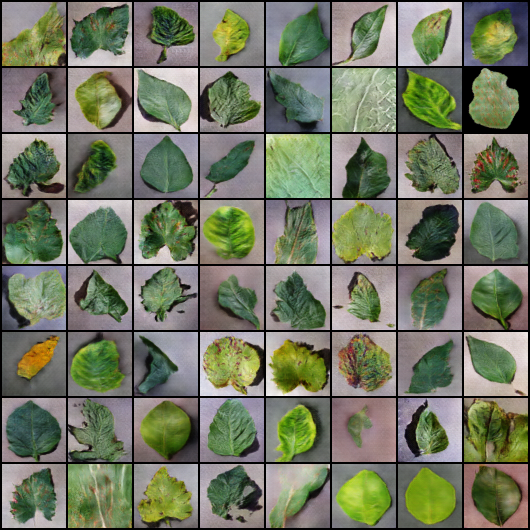

In [33]:
Image('./generated/generated-images-0001.png')

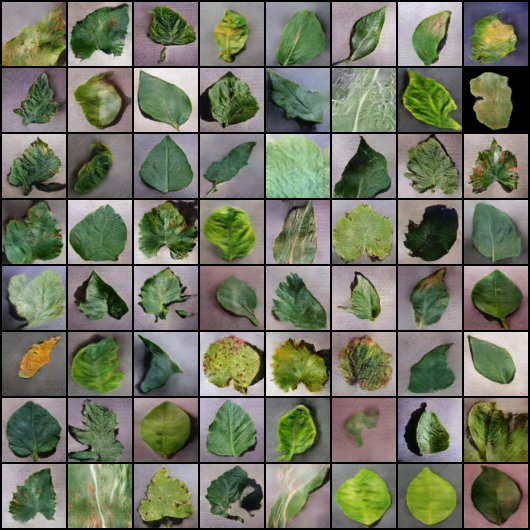

In [34]:
Image('./generated/generated-images-0010.png')

In [35]:
Image('./generated/generated-images-0050.png')

In [36]:
Image('./generated/generated-images-0100.png')

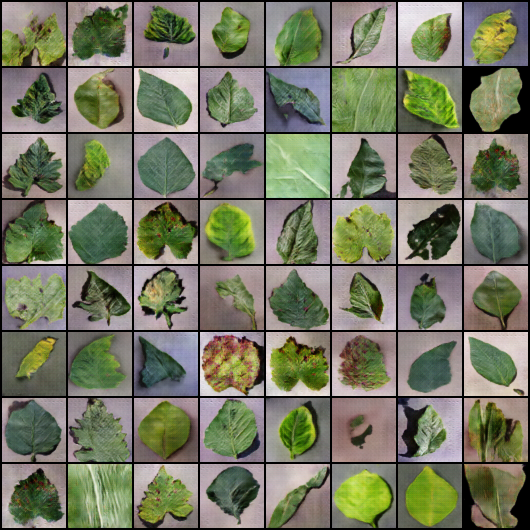

In [37]:
Image('./generated/generated-images-0150.png')

In [38]:
Image('./generated/generated-images-0200.png')

## Combining the sample images and making video using OpenCV.


In [39]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


## Generate Images

In [122]:
def save_samples(index, latent_tensors):
    fake_images = generator(latent_tensors)
    x = range(64)
    for i in x:
        fake_fname = 'Image-{0}-{1}.png'.format(index, i)
        save_image(denorm(fake_images[1]), os.path.join('/kaggle/working/', fake_fname))

In [119]:
x = range(1000)
for i in x:
    fixed_latent_ = torch.randn(64, latent_size, 1, 1, device=device)
    save_samples(i, fixed_latent_)

In [121]:
from zipfile import ZipFile
import os

zipObj = ZipFile('GeneratedImages.zip', 'w')

for filename in os.listdir("/kaggle/working"):
    if filename[0] == 'I':
        zipObj.write(filename)
zipObj.close()